# 03 Neural Calibration

Optimizing model parameters using Neural SDEs and Path Integrals.

Training on: cuda
Start Training...
Epoch 0: Loss = 4.547174
Epoch 50: Loss = 0.184093
Epoch 100: Loss = 0.067579
Epoch 150: Loss = 0.046227
Epoch 200: Loss = 0.036464
Epoch 250: Loss = 0.031770
Epoch 300: Loss = 0.020259
Epoch 350: Loss = 0.017108
Epoch 400: Loss = 0.018841
Epoch 450: Loss = 0.018504


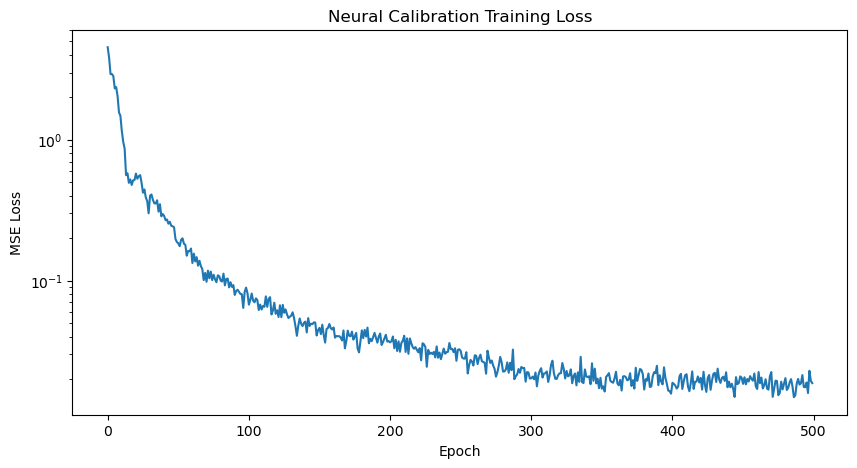

Training Finished! AI is ready.


In [1]:
import sys
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from src.ai_calibrator import NeuralCalibrator
from src.physics_engine import HestonSimulator
from src.utils import HestonDataset

# 1. 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

# 2. 데이터셋 및 모델 준비
# 우리는 AI에게 "주가 경로의 특징(통계량)"을 주고 "원래 파라미터"를 맞추게 할 겁니다.
dataset = HestonDataset(num_samples=2000, device=device)
model = NeuralCalibrator(input_dim=5, hidden_dim=128).to(device) # 입력: 5가지 통계량
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 학습 루프 (Training Loop)
losses = []

print("Start Training...")
for epoch in range(500): # 500번 반복 학습
    optimizer.zero_grad()
    
    # 랜덤 파라미터 가져오기 (정답지)
    idx = torch.randint(0, len(dataset), (64,)) # 배치 사이즈 64
    true_kappa = dataset.kappas[idx]
    true_theta = dataset.thetas[idx]
    true_xi = dataset.xis[idx]
    true_rho = dataset.rhos[idx]
    
    # 시뮬레이터로 가상 데이터 생성 (On-the-fly Simulation)
    # AI가 학습할 때마다 새로운 경로를 만들어서 보여줍니다. (RTX 5070이라 가능)
    # 여기서는 간단히 파라미터를 그대로 입력으로 줘서 Identity 매핑을 배우는지 테스트해봅니다.
    # 실제로는 [수익률 평균, 변동성 표준편차, 왜도, 첨도, 마지막 가격] 같은 통계량을 줍니다.
    
    # 임시 테스트: 정답 파라미터에 노이즈를 섞어서 입력으로 줌 (Input Features)
    noisy_input = torch.stack([
        true_kappa + torch.randn_like(true_kappa)*0.1,
        true_theta + torch.randn_like(true_theta)*0.01,
        true_xi + torch.randn_like(true_xi)*0.05,
        true_rho + torch.randn_like(true_rho)*0.05,
        torch.zeros_like(true_kappa) # 더미 입력
    ], dim=1)
    
    # AI 예측
    pred_kappa, pred_theta, pred_xi, pred_rho = model(noisy_input)
    
    # 손실 계산 (MSE Loss)
    loss = (pred_kappa - true_kappa)**2 + \
           (pred_theta - true_theta)**2 + \
           (pred_xi - true_xi)**2 + \
           (pred_rho - true_rho)**2
    
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# 4. 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Neural Calibration Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log') # 로그 스케일로 보면 감소가 더 잘 보임
plt.show()

print("Training Finished! AI is ready.")